In [1]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam,RMSprop

In [2]:
file_name = "../data/FTSE_2023_02_27.csv"
data = pd.DataFrame(pd.read_csv(file_name))

In [3]:
data['return'] = np.log(data['Close']/data['Close'].shift(1))
data['direction'] = np.where(data['return'] > 0, 1, 0)

lags = 5
cols = []
for lag in range(1, lags + 1):
    col = f'lag_{lag}'
    data[col] = data['return'].shift(lag)
    cols.append(col)
    
data['momentum'] = data['return'].rolling(5).mean().shift(1)
data['volatility'] = data['return'].rolling(20).std().shift(1)
data['distance'] = (data['Close'] - data['Close'].rolling(50).mean()).shift(1)
data.dropna(inplace=True)
cols.extend(['momentum', 'volatility', 'distance']) 

/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [4]:
data.head()

,Exchange Date,Close,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5,momentum,volatility,distance
50,2004-03-12,8055.956288,-0.000005,0,-0.018075,-0.010503,-0.015920,0.003406,0.009586,-0.006301,0.011722,-181.328585
51,2004-03-15,7968.454316,-0.010921,0,-0.000005,-0.018075,-0.010503,-0.015920,0.003406,-0.008220,0.011650,-180.835791
52,2004-03-16,8022.933536,0.006814,1,-0.010921,-0.000005,-0.018075,-0.010503,-0.015920,-0.011085,0.011801,-264.679469
53,2004-03-17,8094.001417,0.008819,1,0.006814,-0.010921,-0.000005,-0.018075,-0.010503,-0.006538,0.010885,-206.516390
54,2004-03-18,8060.907658,-0.004097,0,0.008819,0.006814,-0.010921,-0.000005,-0.018075,-0.002674,0.010860,-134.680998


In [5]:
data.round(4).tail()

,Exchange Date,Close,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5,momentum,volatility,distance
4836,2023-02-20,9647.6586,0.0015,1,0.0025,-0.0009,-0.0064,0.0037,0.0146,0.0027,0.0062,258.8043
4837,2023-02-21,9665.0796,0.0018,1,0.0015,0.0025,-0.0009,-0.0064,0.0037,0.0001,0.0062,262.9854
4838,2023-02-22,9551.6386,-0.0118,0,0.0018,0.0015,0.0025,-0.0009,-0.0064,-0.0003,0.0060,269.9191
4839,2023-02-23,9499.5615,-0.0055,0,-0.0118,0.0018,0.0015,0.0025,-0.0009,-0.0014,0.0065,148.6983
4840,2023-02-24,9410.2766,-0.0094,0,-0.0055,-0.0118,0.0018,0.0015,0.0025,-0.0023,0.0066,89.3532


In [6]:
def set_seeds(seed=100): 
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [7]:
start_date = '2013-01-04'
cutoff_date = '2022-01-04'

In [8]:
start_index = data.index[data['Exchange Date'] == start_date][0]
cutoff_index = data.index[data['Exchange Date'] == cutoff_date][0]

In [9]:
training_data = data[start_index:cutoff_index].copy()
mu, std = training_data.mean(numeric_only=True), training_data.std(numeric_only=True)
training_data_ = (training_data - mu)/std

test_data = data[cutoff_index:].copy()
mu_test, std_test = test_data.mean(numeric_only=True), test_data.std(numeric_only=True)
test_data_ = (test_data - mu_test)/std_test

In [10]:
seed = 100
set_seeds(seed)

optimizer = Adam(learning_rate=0.0001)

model = Sequential()
model.add(Dense(16, activation='relu',
      input_shape=(len(cols),)))
model.add(Dropout(0.1))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy'])

2023-02-27 17:41:40.674748: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
%%time
model.fit(training_data[cols], training_data['direction'], epochs=50, verbose=False, 
          validation_split=0.2, shuffle=False)

/usr/local/lib/python3.10/site-packages/keras/engine/data_adapter.py:1506: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


CPU times: user 5.21 s, sys: 572 ms, total: 5.78 s
Wall time: 4.63 s


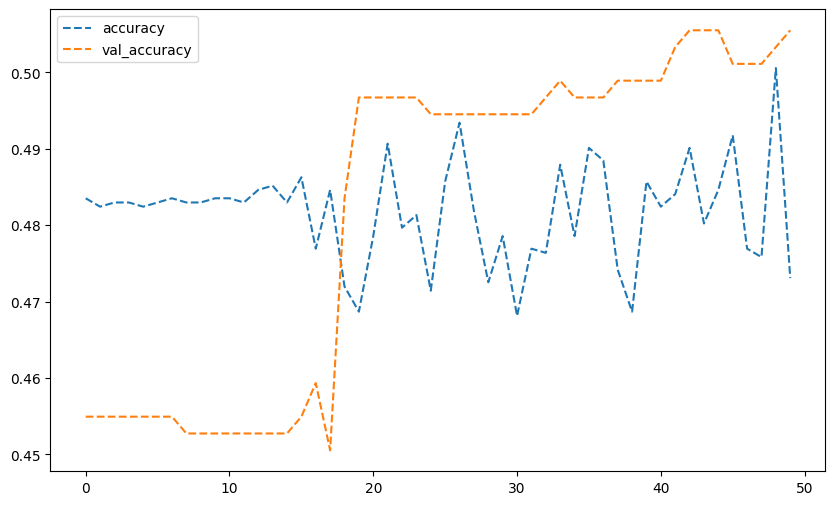

In [12]:
res = pd.DataFrame(model.history.history)
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

In [13]:
model.evaluate(test_data_[cols], test_data['direction'])

8/8 [==============================] - 0s 1ms/step - loss: 0.6882 - accuracy: 0.5481


[0.6882219910621643, 0.5481171607971191]

In [14]:
pred = np.where(model.predict(test_data_[cols]) > 0.5, 1, 0)
test_data['prediction'] = np.where(pred > 0, 1, -1)
test_data['prediction'].value_counts()

 1    227
-1     12
Name: prediction, dtype: int64

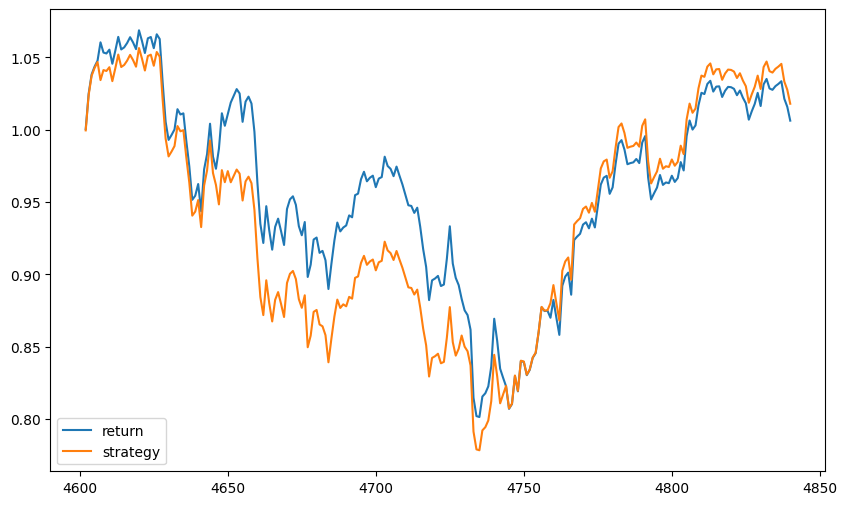

In [15]:
test_data['strategy'] = (test_data['prediction'] * test_data['return'])
test_data[['return', 'strategy']].sum().apply(np.exp)
test_data[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6));

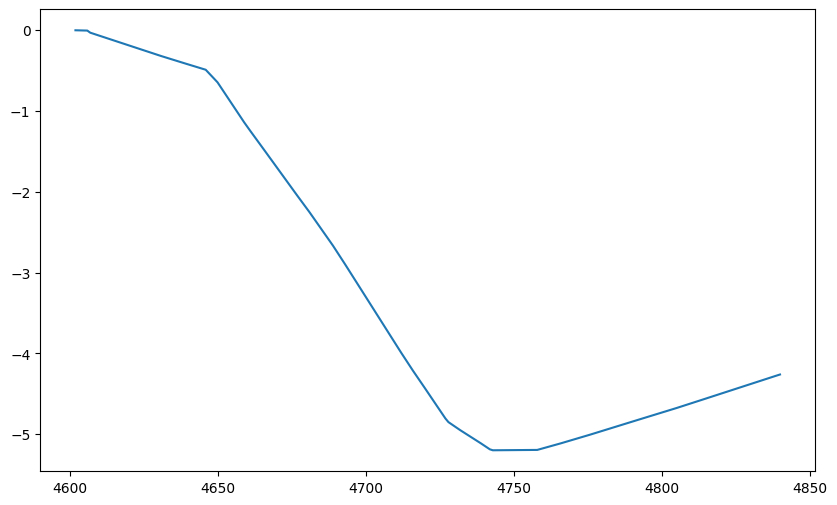

In [16]:
test_data['difference'] = test_data['strategy'].cumsum().apply(np.exp) - test_data['return'].cumsum().apply(np.exp)
test_data['difference'].cumsum().plot(figsize=(10, 6));